Git repo: https://github.com/lleviraz/bert-gender-bias

This is the second part of an Advanced ML Course Final Project, Reichman University, 2022.


Part 2.B :Training the probe to detect gender bias in a model's latent space.


---
By: Eli Terris-Assa and Liad Levi-Raz




This notebook is comprised of the steps taken to create and train a custom bert model made out of a previous bert model's layers up to and including the encoder and a simple probe tasked in predicting a different task from the original bert model's task
 
 
Running this will **not use any preset weights for the probe layers, and will train on the given data**. This task takes about **1~2.5** hours depending on GPU capacity, number of epochs and patience. 



# Setup

In [ ]:
from IPython.display import clear_output

In [ ]:
# in case of saving in google drive through colab
#from google.colab import drive
#drive.mount('/content/')

Mounted at /content/drive


In [ ]:
# where to save logs and df
env = '/content/'

In [ ]:
!pip install transformers
clear_output()

In [ ]:
!pip install gdown
!pip install  simpletransformers gensim transformers-interpret -q
clear_output()

In [ ]:
import pandas as pd 
import torch
import transformers
import numpy as np
from transformers import AutoModel,BertForSequenceClassification 
import matplotlib.pyplot as plt


In [ ]:
import os
import gdown 
from simpletransformers.classification import ClassificationModel, ClassificationArgs


In [ ]:
def download_from_gdrive(file_id,dest_path):
  if(not os.path.exists(dest_path)):
    url = 'https://drive.google.com/uc?id='+file_id
    gdown.download(url, dest_path, quiet=False)
  else:
    print('{} already exists'.format(dest_path))

# loading data original data

In [ ]:
VOCAB_FILE='dreaddit_vocab.txt'
DATASET_FILE='dreaddit_data.zip'

In [ ]:
download_from_gdrive('1q6wpGrdvgNihjoLwlooQiFcUSVmNCsTS',DATASET_FILE)

Downloading...
From: https://drive.google.com/uc?id=1q6wpGrdvgNihjoLwlooQiFcUSVmNCsTS
To: /content/dreaddit_data.zip
100%|██████████| 1.35M/1.35M [00:00<00:00, 164MB/s]


In [ ]:
download_from_gdrive('1Q2Fpg3K0ayRtXsjRQAdXHnUp0rYoCgjj',VOCAB_FILE)

Downloading...
From: https://drive.google.com/uc?id=1Q2Fpg3K0ayRtXsjRQAdXHnUp0rYoCgjj
To: /content/dreaddit_vocab.txt
100%|██████████| 44.3M/44.3M [00:00<00:00, 177MB/s]


In [ ]:
!mkdir -p data 
!unzip -n dreaddit_data.zip -d data

Archive:  dreaddit_data.zip
  inflating: data/dreaddit-train.csv  
  inflating: data/dreaddit-test.csv  


In [ ]:
df_train = pd.read_csv("data/dreaddit-train.csv")
df_test = pd.read_csv("data/dreaddit-test.csv")


In [ ]:
df_train = df_train[['text','label','id']]
df_test = df_test[['text','label','id']]

In [ ]:
df_train.head(8)

,text,label,id
0,"He said he had not felt that way before, sugge...",1,33181
1,"Hey there r/assistance, Not sure if this is th...",0,2606
2,My mom then hit me with the newspaper and it s...,1,38816
3,"until i met my new boyfriend, he is amazing, h...",1,239
4,October is Domestic Violence Awareness Month a...,1,1421
5,I think he doesn't want to put in the effort f...,1,17554
6,It was a big company so luckily I didn't have ...,0,165
7,It cleared up and I was okay but. On Monday ...,1,33053


In [ ]:
len(df_train),len(df_test)

(2838, 715)

# loading models and creating labels

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_length = 128


In [ ]:
#w2v_tok = transformers.BertTokenizer(env+'dreaddit_vocab.txt') VOCAB_FILE
w2v_tok = transformers.BertTokenizer(VOCAB_FILE)

In [ ]:
P2_TRAINED_MODEL='bert_dreaddit_gender_model_part2.zip'
download_from_gdrive('1uim3vGMQ_oUhpM6l7tsQ9nYypQaYsf3O',P2_TRAINED_MODEL)
P2_INFERENCE_MODE = os.path.isfile(P2_TRAINED_MODEL)

Downloading...
From: https://drive.google.com/uc?id=1uim3vGMQ_oUhpM6l7tsQ9nYypQaYsf3O
To: /content/bert_dreaddit_gender_model_part2.zip
100%|██████████| 402M/402M [00:03<00:00, 119MB/s]


In [ ]:
print('Inference mode, loading best model...')
!unzip -q -n {P2_TRAINED_MODEL}
# Create a ClassificationModel
model2 = ClassificationModel(
    "bert", '/content/part2_outputs',
    tokenizer_type=w2v_tok,
    use_cuda=torch.cuda.is_available()
)
print('Best model loaded.')

Inference mode, loading best model...
Best model loaded.


In [ ]:
#model2.predict(list(df_test['text'][:1]))

In [ ]:
model2.model.base_model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(28996, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
#model_gender = BertForSequenceClassification.from_pretrained("Cameron/BERT-rtgender-opgender-annotations").to(device)
#model_gender = BertForSequenceClassification.from_pretrained(env+"outputs/gender_classifier").to(device)
#model_gender.resize_token_embeddings(3000002)

def prepare_data(data, batch_size = 32):
  data = data.copy()
  
  
  data_sequences = []
  batches = np.ceil(len(data)/batch_size)
  for batch in range(int(batches)):
    start_idx = batch * batch_size
    end_idx = start_idx + batch_size
    if end_idx > len(data):
        end_idx = len(data)
    

    texts = list(data['text'].iloc[start_idx:end_idx])
    labels = list(data['label'].iloc[start_idx:end_idx])
    inputs = w2v_tok(texts, return_tensors="pt", truncation = True, padding = True, max_length=text_length) # add things
    with torch.no_grad():
        logits = model2.predict(texts)[1]
        #data['logits_0'].iloc[start_idx:end_idx] = logits[:,0].tolist()
        #data['logits_1'].iloc[start_idx:end_idx] = logits[:,1].tolist()
        #logits = model_stress_encoder(model_stress_embeddings.forward(inputs['input_ids']),inputs['attention_mask'])
        #print(logits)
        datum = (inputs,labels,logits)
        data_sequences.append(datum)
    
  return data_sequences


train = prepare_data(df_train)
test = prepare_data(df_test)

#model_gender.resize_token_embeddings(30002)
#del model_gender; 
torch.cuda.empty_cache()
clear_output()

In [ ]:
#train[0]

In [ ]:
#model_stress = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Studies/Adv Machine Learning/Final project/outputs/best_model").to(device)
#model_stress.resize_token_embeddings(3000002)


# create the bert and probe custom model

In [ ]:
def get_parameters(params, freeze_from = 0, freeze_last_until=0,verbose = False):
    output = []
    
    
    temp = list(params)
    count = 0
    for name, param in temp[:freeze_from]: 
        if verbose:
          print('I won\'t be frozen: {}'.format(name)) 
        param.requires_grad = True
        output.append(param)
        count+=len(param)

    for name, param in temp[freeze_from:(-1)*freeze_last_until]: 
        if verbose:
          print('I will be frozen: {}'.format(name)) 
        param.requires_grad = False
    
    for name, param in temp[(-1)*freeze_last_until:]: 
        if verbose:
          print('I won\'t be frozen: {}'.format(name)) 
        param.requires_grad = True
        output.append(param)
        count+=len(param)

    print(f'Number of params = {count}')
    return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
TRAINED_MODEL='bert_dreaddit_stress_model_part2.zip'
download_from_gdrive('1a4Qym6w7z-tmsjoZ7WJ3-Ft1doZ-gHTW',TRAINED_MODEL)
INFERENCE_MODE = os.path.isfile(TRAINED_MODEL)

Downloading...
From: https://drive.google.com/uc?id=1a4Qym6w7z-tmsjoZ7WJ3-Ft1doZ-gHTW
To: /content/bert_dreaddit_stress_model_part2.zip
100%|██████████| 1.14G/1.14G [00:09<00:00, 120MB/s]


In [ ]:
print('Inference mode, loading best model...')
!unzip -q -n {TRAINED_MODEL}
# Create a ClassificationModel
bert = ClassificationModel(
    "bert", "outputs/best_model",
    tokenizer_type=w2v_tok,
    use_cuda=torch.cuda.is_available()
)
print('Best model loaded.')

Inference mode, loading best model...
Best model loaded.


In [ ]:
import torch

class CustomBERTModel(torch.nn.Module):
    def __init__(self,model):
          super(CustomBERTModel, self).__init__()          
          model.resize_token_embeddings(3000002)
          self.model_stress_embeddings = model.base_model.embeddings
          self.model_stress_encoder = model.base_model.encoder

          # add the probe
          self.linear1 = torch.nn.Linear(768*text_length, 768*2)  
          self.batchnorm = torch.nn.BatchNorm1d(768*2)
          self.linear2 = torch.nn.Linear(768*2, 2)

          
    def forward(self, input_ids, attention_mask):
          embedding_output = self.model_stress_embeddings(input_ids=input_ids)
          encoder_output = self.model_stress_encoder(embedding_output).last_hidden_state
          logits = self.linear1(encoder_output.view(-1,768*text_length))
          logits = self.batchnorm(logits)
          logits = self.linear2(logits)
          
          return logits

In [ ]:
bert_and_probe = CustomBERTModel(bert.model).to(device)
optimizer = torch.optim.AdamW(get_parameters(bert_and_probe.named_parameters(),0,6,verbose = True), lr=0.000001)

I will be frozen: model_stress_embeddings.word_embeddings.weight
I will be frozen: model_stress_embeddings.position_embeddings.weight
I will be frozen: model_stress_embeddings.token_type_embeddings.weight
I will be frozen: model_stress_embeddings.LayerNorm.weight
I will be frozen: model_stress_embeddings.LayerNorm.bias
I will be frozen: model_stress_encoder.layer.0.attention.self.query.weight
I will be frozen: model_stress_encoder.layer.0.attention.self.query.bias
I will be frozen: model_stress_encoder.layer.0.attention.self.key.weight
I will be frozen: model_stress_encoder.layer.0.attention.self.key.bias
I will be frozen: model_stress_encoder.layer.0.attention.self.value.weight
I will be frozen: model_stress_encoder.layer.0.attention.self.value.bias
I will be frozen: model_stress_encoder.layer.0.attention.output.dense.weight
I will be frozen: model_stress_encoder.layer.0.attention.output.dense.bias
I will be frozen: model_stress_encoder.layer.0.attention.output.LayerNorm.weight
I will

In [ ]:
#from torchviz import make_dot

#make_dot(yhat, params=dict(list(bert_and_probe.named_parameters()))).render("bert_torchviz", format="png")

# train the probe

In [ ]:
from sklearn.metrics import confusion_matrix
def train_loop_probe(model, n_epochs, train_data, dev_data):
  # Loss function
  criterion1 = torch.nn.MSELoss() #other options:  HuberLoss  L1Loss
  criterion2 = torch.nn.MSELoss()
  best_loss = np.inf
  patience = 10
  triggertimes = 0
  hist_loss_train = []
  hist_loss_val = []

  hist_tp_train = []
  hist_tn_train = []
  hist_fp_train = []
  hist_fn_train = []

  hist_tp_val = []
  hist_tn_val = []
  hist_fp_val = []
  hist_fn_val = []
  for e in range(1, n_epochs + 1):
      #TRAIN
      model.train()
      train_loss_total = 0
      y_hat_train = []
      y_train = []
      for batch in train_data:
          inputs,labels,logits = batch
          logits = torch.tensor(logits, dtype = torch.float).to(device)

          input_ids = inputs['input_ids']
          attention_mask = inputs['attention_mask']
          model.zero_grad()

          
          outputs = model(input_ids=input_ids.to(device),
                          attention_mask=attention_mask.to(device))
          
          y_hat_train.extend(np.argmax(outputs.cpu().detach().numpy(),axis =1 ))
          y_train.extend(np.argmax(logits.cpu().detach().numpy(),axis =1 ))

          loss = criterion1(outputs.view(-1,2), logits.view(-1,2))
          

          loss.backward()
          train_loss_total+=loss.item()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          
      
      # DEV
      model.eval()
      dev_loss_total = 0
      y_hat_val = []
      y_val = []
      with torch.no_grad():
          for batch in dev_data:
              inputs,labels,logits = batch
              logits = torch.tensor(logits, dtype = torch.float).to(device)

              input_ids = inputs['input_ids']
              attention_mask = inputs['attention_mask']

              outputs = model(input_ids=input_ids.to(device),
                          attention_mask=attention_mask.to(device))
              
              y_hat_val.extend(np.argmax(outputs.cpu().detach().numpy(),axis =1 ))
              y_val.extend(np.argmax(logits.cpu().detach().numpy(),axis =1 ))
              
              loss = criterion2(outputs.view(-1,2), logits.view(-1, 2))

              
              
              dev_loss_total += loss.item()
      
      
      current_train_loss = train_loss_total/len(train_data)
      current_val_loss = dev_loss_total/len(dev_data)
      hist_loss_train.append(current_train_loss)
      hist_loss_val.append(current_val_loss)

      
      tn, fp, fn, tp = confusion_matrix(y_train, y_hat_train).ravel()
      hist_tp_train.append(tp)
      hist_tn_train.append(tn)
      hist_fp_train.append(fp)
      hist_fn_train.append(fn)
      print(f'Train : TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')


      
      tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
      hist_tp_val.append(tp)
      hist_tn_val.append(tn)
      hist_fp_val.append(fp)
      hist_fn_val.append(fn)
      
      print(f'Val : TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')

      print(f"Epoch {e}, Train loss = {current_train_loss}, Dev loss = {current_val_loss}")

      # choose to use train loss or val loss for earlystopping
      patience_loss = train_loss_total
      if patience_loss >= best_loss:
        print('Triggered')
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            model.load_state_dict(best_model_dict)

            df = pd.DataFrame()
            df['tp_train'] = hist_tp_train
            df['tn_train'] = hist_tn_train
            df['fp_train'] = hist_fp_train
            df['fn_train'] = hist_fn_train
            
            df['tp_val'] = hist_tp_val
            df['tn_val'] = hist_tn_val
            df['fp_val'] = hist_fp_val
            df['fn_val'] = hist_fn_val

            df['train_loss'] = hist_loss_train
            df['val_loss'] = hist_loss_val
            return df
      else:
        best_loss = patience_loss
        best_model_dict = model.state_dict()
        trigger_times = 0

        
        torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hist_loss_train': hist_loss_train,
        'hist_loss_val': hist_loss_val
                    }, env+'best_1.pth')
      
  df = pd.DataFrame()
  df['tp_train'] = hist_tp_train
  df['tn_train'] = hist_tn_train
  df['fp_train'] = hist_fp_train
  df['fn_train'] = hist_fn_train
  
  df['tp_val'] = hist_tp_val
  df['tn_val'] = hist_tn_val
  df['fp_val'] = hist_fp_val
  df['fn_val'] = hist_fn_val

  df['train_loss'] = hist_loss_train
  df['val_loss'] = hist_loss_val
  return df

In [ ]:
df = train_loop_probe(bert_and_probe, n_epochs=1000,
                 train_data=train, dev_data=test)

Train : TP = 420, TN = 1107, FP = 1006, FN = 305
Val : TP = 163, TN = 74, FP = 459, FN = 19
Epoch 1, Train loss = 9.133581777636925, Dev loss = 12.520495953767195
Train : TP = 482, TN = 1175, FP = 938, FN = 243
Val : TP = 173, TN = 39, FP = 494, FN = 9
Epoch 2, Train loss = 8.763163936272097, Dev loss = 15.23002288652503
Train : TP = 473, TN = 1180, FP = 933, FN = 252
Val : TP = 171, TN = 43, FP = 490, FN = 11
Epoch 3, Train loss = 8.657809053913931, Dev loss = 15.616560314012611
Train : TP = 509, TN = 1208, FP = 905, FN = 216
Val : TP = 177, TN = 30, FP = 503, FN = 5
Epoch 4, Train loss = 8.483783941590383, Dev loss = 17.734655504641324
Train : TP = 537, TN = 1232, FP = 881, FN = 188
Val : TP = 136, TN = 181, FP = 352, FN = 46
Epoch 5, Train loss = 8.285139083862305, Dev loss = 11.0061674947324
Train : TP = 525, TN = 1262, FP = 851, FN = 200
Val : TP = 136, TN = 180, FP = 353, FN = 46
Epoch 6, Train loss = 8.13501799508427, Dev loss = 10.917963898700217
Train : TP = 538, TN = 1237, FP

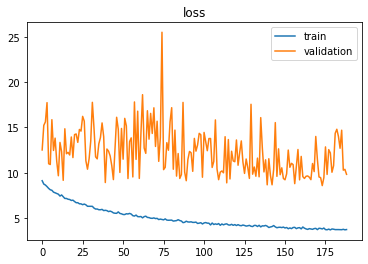

In [ ]:
plt.plot(range(len(df)),df['train_loss'],df['val_loss'])
plt.legend(['train','validation'])
plt.title('loss')
plt.show()
#plt.yscale('log')

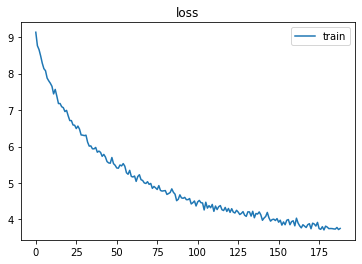

In [ ]:
plt.plot(range(len(df)),df['train_loss'])
plt.legend(['train'])
plt.title('loss')
plt.show()

In [ ]:
recall_train = df['tp_train']/(df['tp_train'] + df['fn_train'])
precision_train = df['tp_train']/(df['tp_train'] + df['fp_train'])


recall_val = df['tp_val']/(df['tp_val'] + df['fn_val'])
precision_val = df['tp_val']/(df['tp_val'] + df['fp_val'])

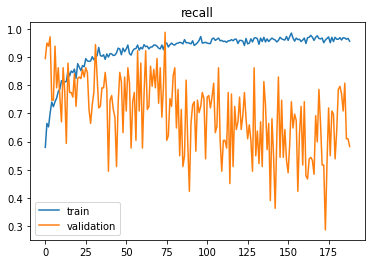

In [ ]:
plt.plot(range(len(df)),recall_train,recall_val)
plt.legend(['train','validation'])
plt.title('recall')
plt.show()


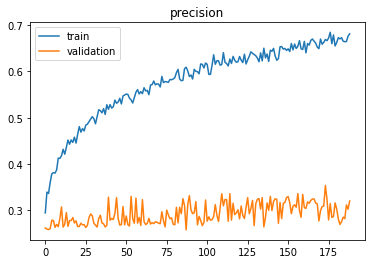

In [ ]:
plt.plot(range(len(df)),precision_train,precision_val)
plt.legend(['train','validation'])
plt.title('precision')
plt.show()


In [ ]:
torch.save({
        'df': df
                    }, env+'results_df.pth')